# Flood Prediction - Lineares Modell 

In diesem Notebook wird das Multivariante Lineare Modell erstellt und trainiert. 

Zunächst müssen alle wichtigen Pakete importiert werden. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl
%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Als Erstes werden die Daten geladen. 

In [4]:
# Daten laden 
data = pd.read_csv('Flut-Daten.csv')
data.head()

,Q,pr,Q_lag_1,Q_lag_2,Q_lag_4,Q_lag_6,Gesamt_pr_6h,Gesamt_pr_12h,Gesamt_pr_24h,Gesamt_Q_6h,Gesamt_Q_12h,Gesamt_Q_24h,rolling_mean_Q_6h,rolling_mean_pr_6h,exp_smooth_Q_3h,exp_smooth_pr_3h,pr_to_Q_ratio,alltime_monthly_avg_pr,alltime_monthly_avg_Q,pr_lag_7
0,2.505459,-0.233655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.513925,-0.305042,-0.219031,0.165176,0.334507,NaN
1,2.459869,-0.233655,2.505453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.483428,-0.305042,-0.219031,0.165176,0.334507,NaN
2,2.413960,-0.233655,2.459862,2.505446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.448392,-0.305042,-0.219031,0.165176,0.334507,NaN
3,2.368051,-0.233655,2.413953,2.459856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.409810,-0.305042,-0.219031,0.165176,0.334507,NaN
4,2.322141,-0.233655,2.368044,2.413947,2.505433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.368611,-0.305042,-0.219031,0.165176,0.334507,NaN


Nun werden unsere Targets (also Q für die nächsten 6 Stunden) erstellt. 

In [5]:
for i in range(1, 7):  
    data[f'target_h{i}'] = data['Q'].shift(-i)

Anschließend werden Fehlende Zielwerte entfernt, da durch die Zeitversetzung bestimmte Features am Anfang und am Ende der Zeitreihe nicht bekannt sind. 

In [7]:
data = data.iloc[8760:-6]  # Entfernt die ersten 365*24 Zeilen und die letzten 6 Zeilen

Anschließend können wir das eigentliche Modell vorbereiten und für jede Stunde trainieren. Auch werden bestimmte Metriken (RMSE, R^2) berechnet. 

In [8]:
# Features und Zielwerte vorbereiten
features = data.drop(columns=['Q'] + [f'target_h{i}' for i in range(1, 7)])
feature_names = features.columns

results = {}

for i in range(1, 7):  

    target = data[f'target_h{i}']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

    # Hinzufügen der Konstante 
    X_train_sm = sm.add_constant(X_train) 
    X_test_sm = sm.add_constant(X_test)


    ols_model = sm.OLS(y_train, X_train_sm).fit()

    train_predictions = ols_model.predict(X_train_sm)
    test_predictions = ols_model.predict(X_test_sm)

    train_rmse = np.sqrt(np.mean((y_train - train_predictions) ** 2))
    test_rmse = np.sqrt(np.mean((y_test - test_predictions) ** 2))

    train_r2 = ols_model.rsquared
    test_r2 = 1 - np.sum((y_test - test_predictions) ** 2) / np.sum((y_test - y_test.mean()) ** 2)

    # Ergebnisse speichern
    results[f'hour_{i}'] = {
        'model': ols_model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': test_predictions,
        'y_test': y_test
    }

    # Ergebnisse ausgeben
    print(f"Ergebnisse für Stunde {i}:")
    print("  Training RMSE:", train_rmse)
    print("  Test RMSE:", test_rmse)
    print("  Training R^2:", train_r2)
    print("  Test R^2:", test_r2)
    print("  Zusammenfassung des Modells:")
    print(ols_model.summary())
    print()

Ergebnisse für Stunde 1:
  Training RMSE: 0.07833154993776875
  Test RMSE: 0.09805101543831364
  Training R^2: 0.9938398938236507
  Test R^2: 0.9909658421559404
  Zusammenfassung des Modells:
                            OLS Regression Results                            
Dep. Variable:              target_h1   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.553e+06
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:22:19   Log-Likelihood:             1.8456e+05
No. Observations:              163636   AIC:                        -3.691e+05
Df Residuals:                  163618   BIC:                        -3.689e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  

Unsere Ergebnisse können wir nun auch in einem Plot visualisieren. 

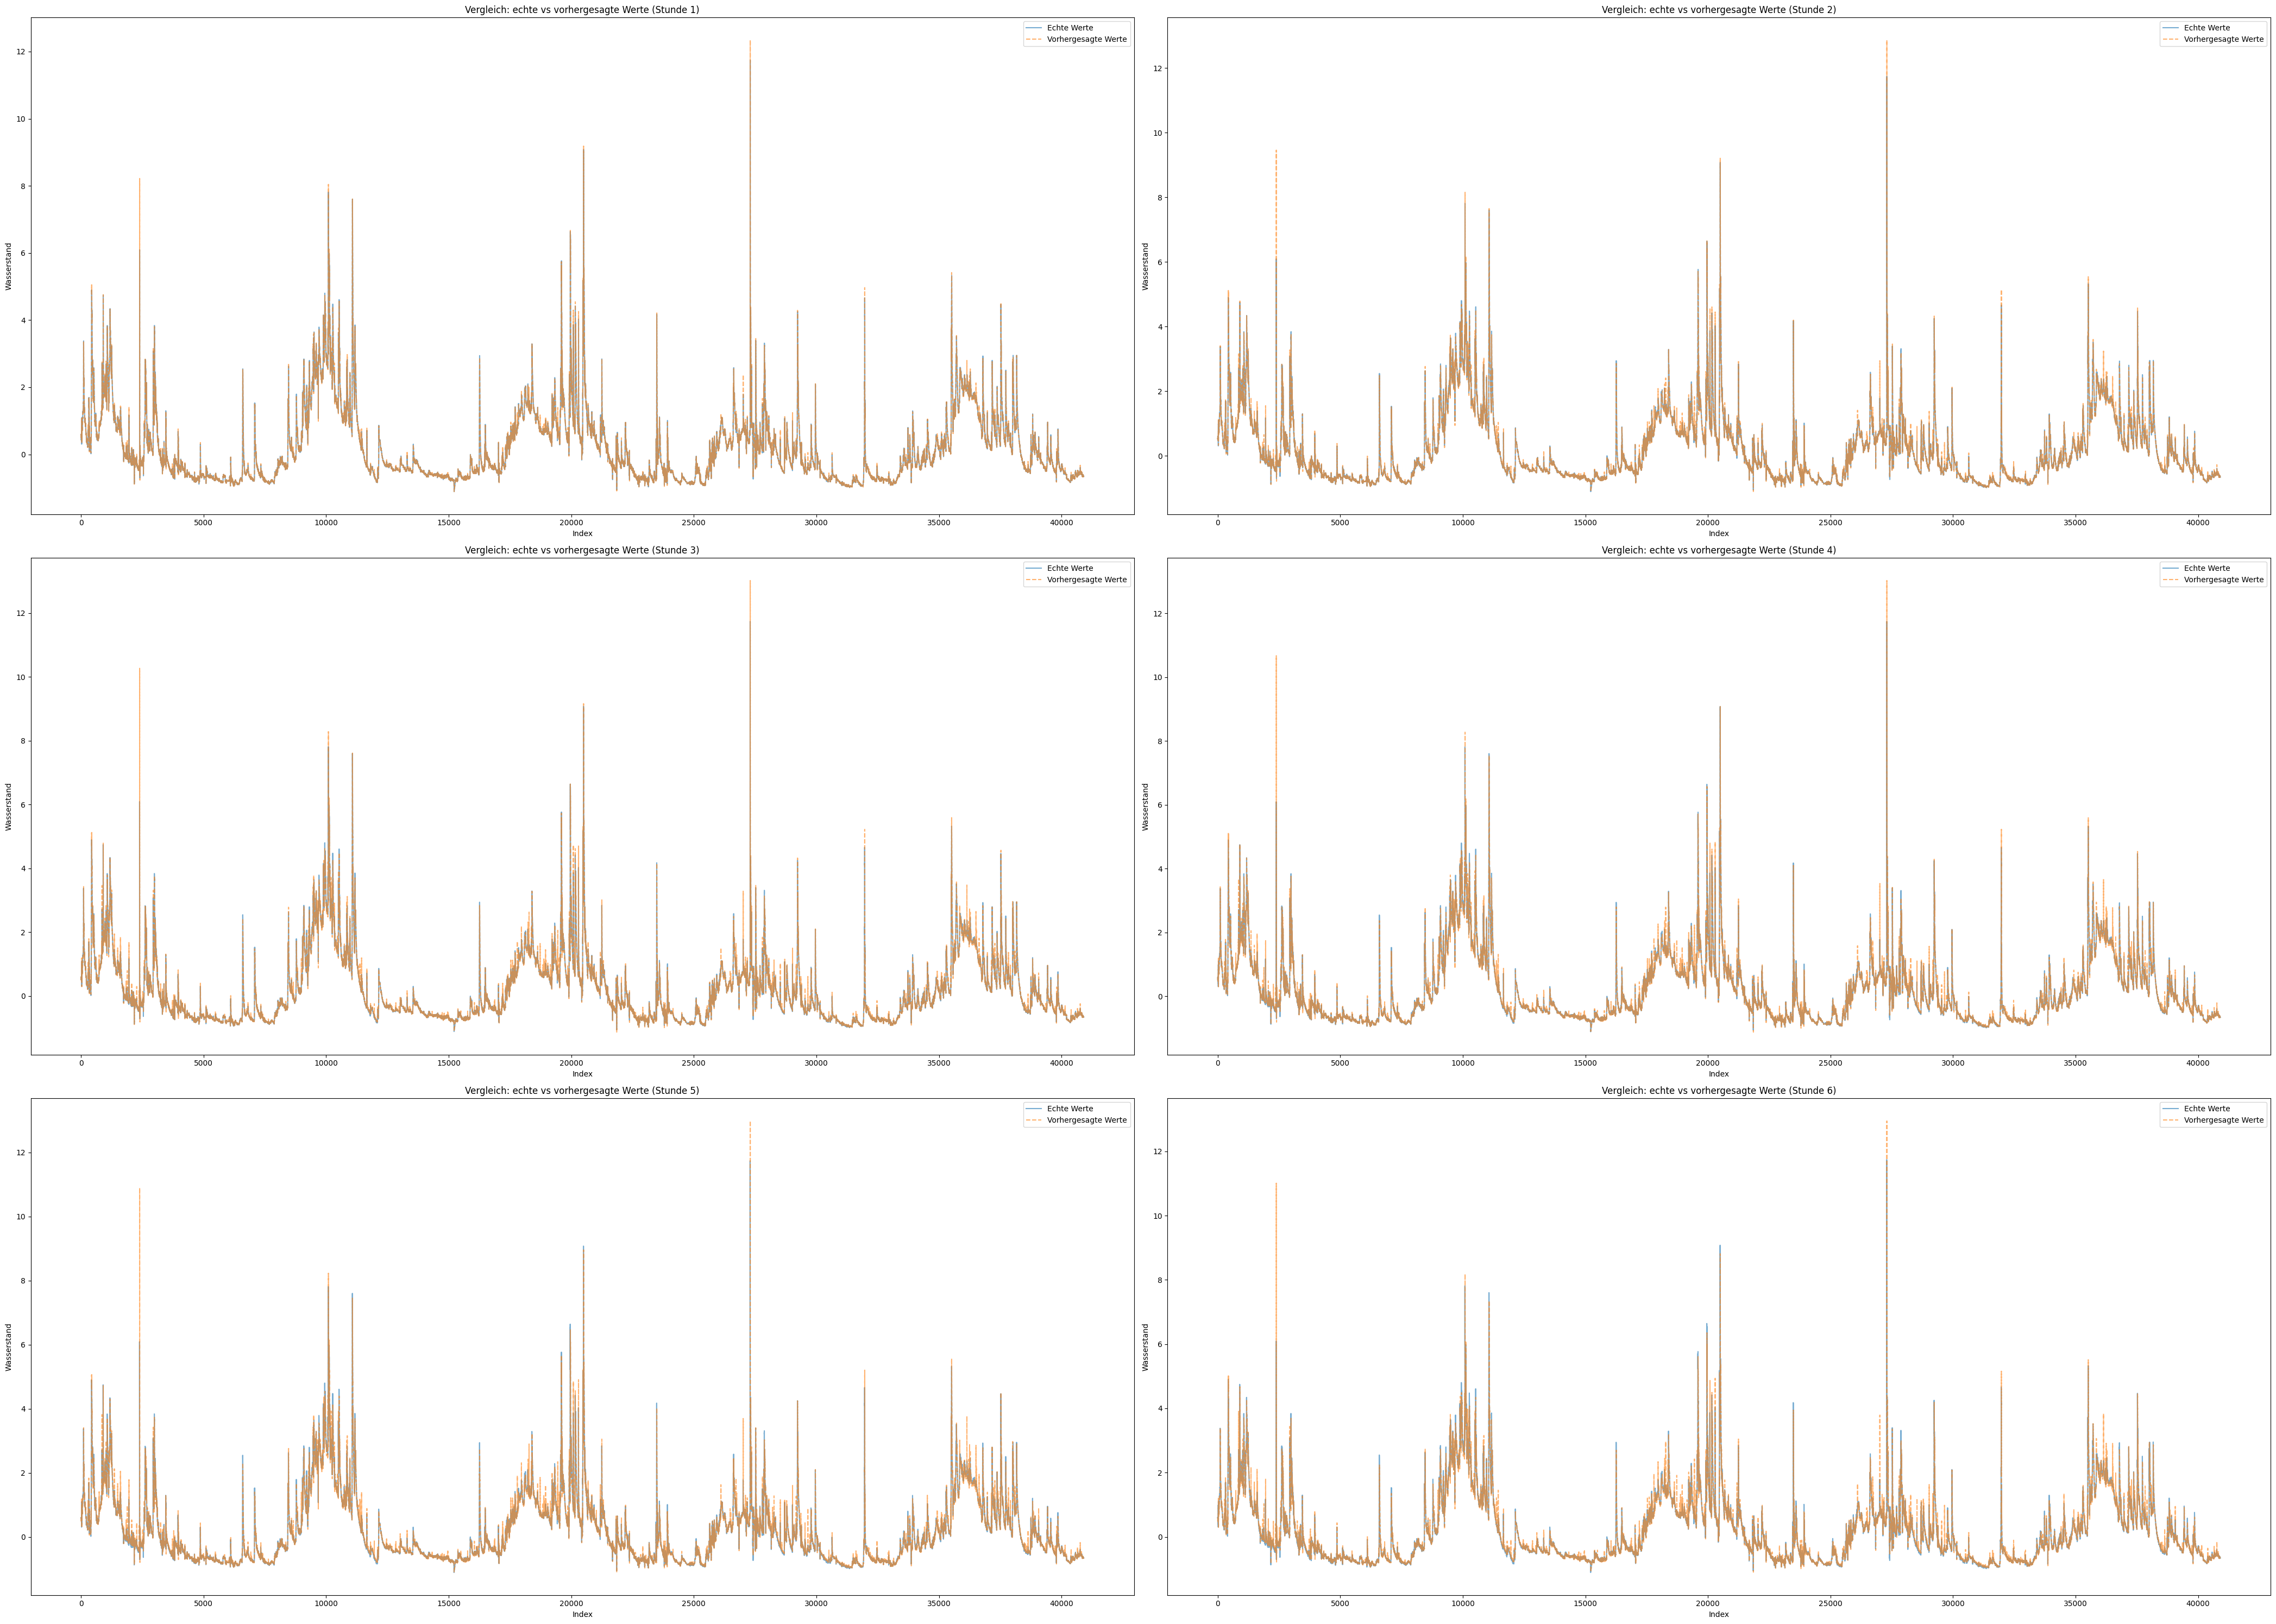

In [9]:
plt.figure(figsize=(42, 30)) 
for i in range(1, 7):
    plt.subplot(3, 2, i)

    # Indizes für y_test und test_predictions müssen übereinstimmen
    y_test_values = results[f'hour_{i}']['y_test'].reset_index(drop=True).values
    test_predictions_values = results[f'hour_{i}']['test_predictions'].reset_index(drop=True).values
    
    plt.plot(y_test_values, label="Echte Werte", alpha=0.6)
    plt.plot(test_predictions_values, label="Vorhergesagte Werte", alpha=0.6, linestyle='--')

    plt.title(f"Vergleich: echte vs vorhergesagte Werte (Stunde {i})")
    plt.xlabel("Index")
    plt.ylabel("Wasserstand")
    plt.legend()

plt.tight_layout()
plt.show()


Man könnte nun auch noch die tatsächlichen Werte gegen die prognostizierten Werte plotten, um sehen zu können, wie nah sich diese Punkte um die Winkelhalbierende befinden. 

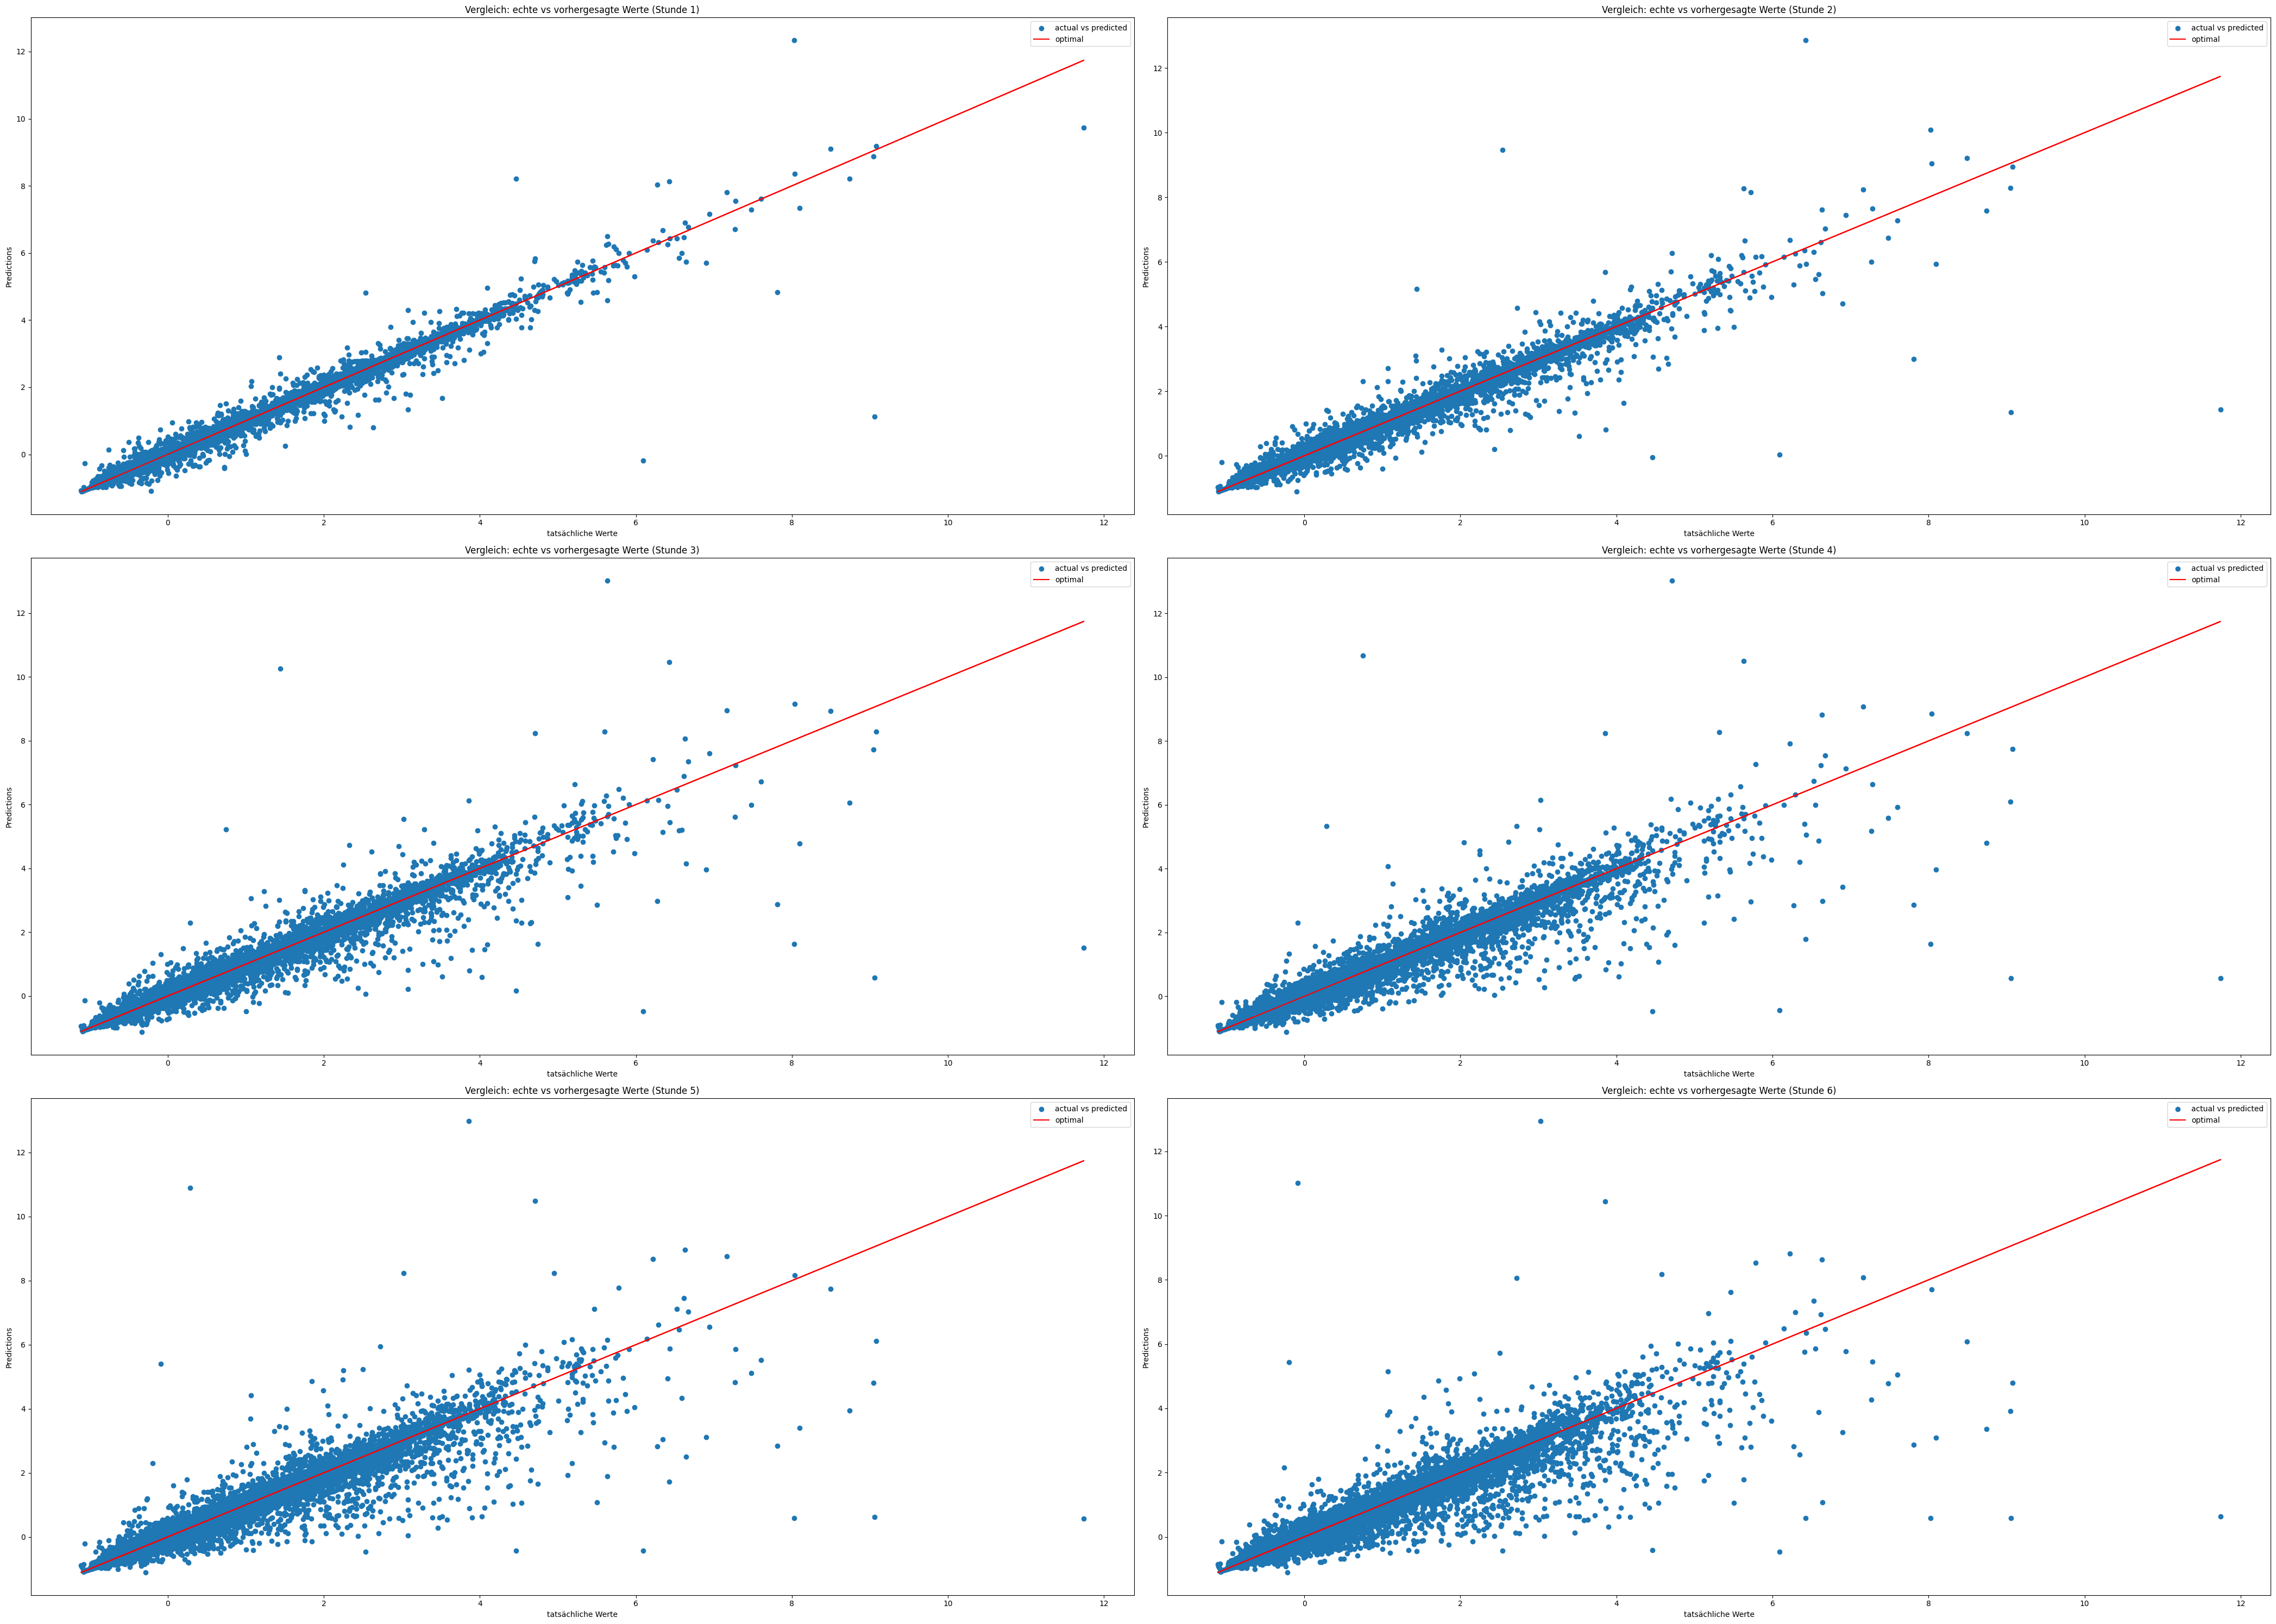

In [10]:
plt.figure(figsize=(42, 30))
for i in range(1, 7):
    plt.subplot(3, 2, i)

    # Indizes für y_test und test_predictions müssen übereinstimmen
    y_test_values = results[f'hour_{i}']['y_test'].reset_index(drop=True).values
    test_predictions_values = results[f'hour_{i}']['test_predictions'].reset_index(drop=True).values
    
    plt.scatter(y_test_values, test_predictions_values, label="actual vs predicted")
    plt.plot(y_test_values, y_test_values, label="optimal", color="red")


    plt.title(f"Vergleich: echte vs vorhergesagte Werte (Stunde {i})")
    plt.xlabel("tatsächliche Werte")
    plt.ylabel("Predictions")
    plt.legend()

plt.tight_layout()
plt.show()